In [1]:
import casadi as ca
import chaospy as cp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [2]:
np.random.seed(13)

In [3]:
def solve_wider_wind_ocp_pce(tf, N, pce_order, k_mean, k_std, s_mean, s_std):
    # Time and discretization
    # tf = tf        # final time [sec]
    # N = N          # number of control intervals
    dt = tf / N    # time step

    # Aircraft physical constants
    m = 4662                # mass [lb sec^2 / ft]
    g = 32.172              # gravity [ft/sec^2]
    delta = 0.03491         # thrust inclination angle [rad]

    # Thrust model coefficients: T = A0 + A1*V + A2*V^2
    A0 = 0.4456e5           # [lb]
    A1 = -0.2398e2          # [lb sec / ft]
    A2 = 0.1442e-1          # [lb sec^2 / ft^2]

    # Aerodynamic model
    rho = 0.2203e-2         # air density [lb sec^2 / ft^4]
    S = 0.1560e4            # reference surface area [ft^2]

    # Wind model 3 beta (smoothing) parameters
    beta0 = 0.4             # initial beta value (approximate)
    beta_dot0 = 0.2         # initial beta rate
    sigma = 3               # time to reach beta = 1 [sec]

    # C_D(alpha) = B0 + B1 * alpha + B2 * alpha**2, D = 0.5 * C_D(α) * ρ * S * V²
    B0 = 0.1552
    B1 = 0.12369            # [1/rad]
    B2 = 2.4203             # [1/rad^2]

    # Lift coefficient: C_L = C0 + C1 * alpha (+ C2 * alpha**2)
    C0 = 0.7125             # baseline lift coefficient
    C1 = 6.0877             # AOA lift slope [1/rad]

    # Lift/drag model optional extensions (if needed)
    C2 = -9.0277            # [rad^-2] — e.g., for moment or drag extension

    # Angle of attack & control constraints
    umax = 0.05236          # max control input (rate of change of alpha) [rad/sec]
    alphamax = 0.3          # max angle of attack [rad]
    alpha_star = 0.20944    # changing pt of AoA

    # Wind model x parameters (piecewise smooth wind)
    a = 6e-8                 # x transition midpoint [ft]
    b = -4e-11               # second transition point [ft]

    # Wind model h parameters (polynomial form)
    c = -np.log(25/30.6)*1e-12      # transition smoothing width [ft]
    d = -8.02881e-8         # polynomial coeff [sec^-1 ft^-2]
    e = 6.28083e-11         # polynomial coeff [sec^-1 ft^-3]

    # Cost function / target altitude
    hR = 1000               # reference altitude [ft]
    h_star = 1000           # used in some wind models

    # Auxiliary
    eps = 1e-6              # to avoid division by zero in V

    # Scaling factors (used if normalizing states)
    xscale = 10000          # [ft]
    hscale = 1000           # [ft]
    Vscale = 240            # [ft/sec]
    gammascale = 0.1        # [rad]
    alphascale = 0.3        # [rad]
    uscale = 0.05           # [rad/sec]

    # PCE parameters
    k_dist = cp.Normal(k_mean, k_std)
    s_dist = cp.Normal(s_mean, s_std)
    joint_dist = cp.J(k_dist, s_dist)
    
    poly_basis = cp.expansion.stieltjes(pce_order, joint_dist)
    nodes, weights = cp.generate_quadrature(pce_order, joint_dist, rule='G')
    # print(poly_basis.shape)     # ((pce_order+1)(pce_order+2)/2, )
    # print(weights.shape)        # ((pce_order+1)^2, )
    # print(nodes.shape)          # (2, (pce_order+1)^2)
    
    M = nodes.shape[1]              # number of PCE samples
    
    weights_dm = ca.DM(weights)   # ((pce_order+1)^2， )
    
    Psi_mat = poly_basis(*nodes)    # (M_poly_basis, (pce_order+1)^2)
    Psi_dm = ca.DM(Psi_mat)         # (M_poly_basis, (pce_order+1)^2)
    

    # Opti instance and scaled variables
    opti = ca.Opti()
    x_s = opti.variable(M, N+1)
    h_s = opti.variable(M, N+1)
    V_s = opti.variable(M, N+1)
    gamma_s = opti.variable(M, N+1)
    alpha_s = opti.variable(M, N+1)
    X_pce = opti.variable(5*(pce_order+1), N+1)
    u_s = opti.variable(N)

    # Unscaled variables for dynamics
    x = x_s * xscale
    h = h_s * hscale
    V = V_s * Vscale
    gamma = gamma_s * gammascale
    alpha = alpha_s * alphascale
    u = u_s * uscale

    def Smooth(x_, x0, x1):
        t = (x_ - x0) / (x1 - x0 + eps)
        return ca.if_else(x_ < x0, 0,
               ca.if_else(x_ > x1, 1, 6*t**5 - 15*t**4 + 10*t**3))

    def A_piecewise(x_, s_):
        A1 = -50 + a * (x_/s_)**3 + b * (x_/s_)**4
        A2 = 0.025 * ((x_/s_) - 2300)
        A3 = 50 - a * (4600 - (x_/s_))**3 - b * (4600 - (x_/s_))**4
        A4 = 50
        s1 = Smooth(x_, 480 * s_, 520 * s_)
        s2 = Smooth(x_, 4080 * s_, 4120 * s_)
        s3 = Smooth(x_, 4580 * s_, 4620 * s_)
        B12 = (1 - s1)*A1 + s1*A2
        B23 = (1 - s2)*A2 + s2*A3
        B34 = (1 - s3)*A3 + s3*A4
        return ca.if_else(x_ <= 500 * s_, B12,
               ca.if_else(x_ <= 4100 * s_, B23,
               ca.if_else(x_ <= 4600 * s_, B34, A4)))

    def B_piecewise(x_, s_):
        B1 = d * (x_/s_)**3 + e * (x_/s_)**4
        B2 = -51 * ca.exp(ca.fmin(-c * ((x_/s_) - 2300)**4, 30))
        B3 = d * (4600 - (x_/s_))**3 + e * (4600 - (x_/s_))**4
        B4 = 0
        s1 = Smooth(x_, 480 * s_, 520 * s_)
        s2 = Smooth(x_, 4080 * s_, 4120 * s_)
        s3 = Smooth(x_, 4580 * s_, 4620 * s_)
        B12 = (1 - s1)*B1 + s1*B2
        B23 = (1 - s2)*B2 + s2*B3
        B34 = (1 - s3)*B3 + s3*B4
        return ca.if_else(x_ <= 500 * s_, B12,
               ca.if_else(x_ <= 4100 * s_, B23,
               ca.if_else(x_ <= 4600 * s_, B34, B4)))

    def wind_x(x_, k_, s_):
        return k_ * A_piecewise(x_, s_)

    def wind_h(x_, h_, k_, s_):
        h_safe = ca.fmax(h_, 10.0)
        return k_ * h_safe / h_star * B_piecewise(x_, s_)

    def C_L(alpha_):
        return ca.if_else(alpha_ > alpha_star, C0 + C1 * alpha_,
                          C0 + C1 * alpha_ + C2 * (alpha_ - alpha_star)**2)
    def beta(t_):
        return ca.if_else(t_ < sigma, beta0 + beta_dot0 * t_, 1.0)

    # Symbolic derivatives
    x_sym = ca.MX.sym("x")
    h_sym = ca.MX.sym("h")
    k_sym = ca.MX.sym("k")
    s_sym = ca.MX.sym("s")
    Wx_expr = wind_x(x_sym, k_sym, s_sym)
    Wh_expr = wind_h(x_sym, h_sym, k_sym, s_sym)
    dWx_dx_fun = ca.Function("dWx_dx", [x_sym, k_sym, s_sym], [ca.gradient(Wx_expr, x_sym)])
    dWh_dx_fun = ca.Function("dWh_dx", [x_sym, h_sym, k_sym, s_sym], [ca.gradient(Wh_expr, x_sym)])
    dWh_dh_fun = ca.Function("dWh_dh", [x_sym, h_sym, k_sym, s_sym], [ca.gradient(Wh_expr, h_sym)])

    def aircraft_ode(X, u_, t_, k_val, s_val):
        x_, h_, V_, gamma_, alpha_ = ca.vertsplit(X)

        T = beta(t_) * (A0 + A1 * V_ + A2 * V_**2)
        D = 0.5 * (B0 + B1 * alpha_ + B2 * alpha_**2) * rho * S * V_**2
        L = 0.5 * rho * S * C_L(alpha_) * V_**2

        Wx = wind_x(x_, k_val, s_val)
        Wh = wind_h(x_, h_, k_val, s_val)
        V_safe = ca.fmax(V_, 1e-3)

        x_dot = V_ * ca.cos(gamma_) + Wx
        h_dot = V_ * ca.sin(gamma_) + Wh

        dWx_dx_val = dWx_dx_fun(x_, k_val, s_val)[0]
        dWh_dx_val = dWh_dx_fun(x_, h_, k_val, s_val)[0]
        dWh_dh_val = dWh_dh_fun(x_, h_, k_val, s_val)[0]

        Wx_dot = dWx_dx_val * x_dot
        Wh_dot = dWh_dx_val * x_dot + dWh_dh_val * h_dot

        V_dot = T / m * ca.cos(alpha_ + delta) - D / m - g * ca.sin(gamma_) - (Wx_dot * ca.cos(gamma_) + Wh_dot * ca.sin(gamma_))
        gamma_dot = T / (m * V_safe) * ca.sin(alpha_ + delta) + L / (m * V_safe) - g / V_safe * ca.cos(gamma_) + (1 / V_safe) * (Wx_dot * ca.sin(gamma_) - Wh_dot * ca.cos(gamma_))
        alpha_dot = u_

        return ca.vertcat(x_dot, h_dot, V_dot, gamma_dot, alpha_dot)

    def rk4_step(f, xk, uk, tk, dt, k_val, s_val):
        k1 = f(xk, uk, tk, k_val, s_val)
        k2 = f(xk + dt/2 * k1, uk, tk + dt/2, k_val, s_val)
        k3 = f(xk + dt/2 * k2, uk, tk + dt/2, k_val, s_val)
        k4 = f(xk + dt * k3, uk, tk + dt, k_val, s_val)
        return xk + dt/6 * (k1 + 2*k2 + 2*k3 + k4)

    J = 0

    # Initial conditions
    opti.subject_to(x_s[:, 0] == 0)
    opti.subject_to(h_s[:, 0] == 600 / hscale)
    opti.subject_to(V_s[:, 0] == 239.7 / Vscale)
    opti.subject_to(gamma_s[:, 0] == -0.03925 / gammascale)
    opti.subject_to(alpha_s[:, 0] == 0.1283 / alphascale)
    opti.subject_to(ca.vec(V_s) >= 1e-2 / Vscale)
    # opti.subject_to(gamma_s[:, -1] == -0.05236 / gammascale)
    opti.subject_to(gamma_s[:, -1] >= 0)
    
    h_ddot_all = [[] for _ in range(N)]
    
    for j in range(M):
        # k_org, s_val = nodes[:, j]
        # k_val = k_org / np.sqrt(s_val)  # Adjust k_val for PCE scaling
        k_val, s_val = nodes[:, j]

        for i in range(N):
            h_physical = h_s[:, i] * hscale
            h_mean = ca.dot(weights_dm, h_physical)

            h_pce_coeffs = ca.mtimes(Psi_dm, weights_dm * h_physical)
            h_high_coeffs = h_pce_coeffs[1:]
            h_std_term = ca.sqrt(ca.sumsqr(h_high_coeffs))

            deviation = hR - h_mean + h_std_term * 12
            scaled_deviation = deviation / hscale
            J += dt * scaled_deviation**6

            tk = i * dt     # New line
            Xk = ca.vertcat(x[j, i], h[j, i], V[j, i], gamma[j, i], alpha[j, i])
            Uk = u[i]
            
            # h_ddot = d^2h/dt^2 = V_dot * sin(gamma) + V * cos(gamma) * gamma_dot + Wh_dot
            ode_out = aircraft_ode(Xk, Uk, tk, k_val, s_val)
            x_dot_k = ode_out[0]
            h_dot_k = ode_out[1]
            V_dot_k = ode_out[2]
            gamma_dot_k = ode_out[3]
            # alpha_dot_k = ode_out[4]
            
            dWh_dx_val = dWh_dx_fun(Xk[0], Xk[1], k_val, s_val)[0]
            dWh_dh_val = dWh_dh_fun(Xk[0], Xk[1], k_val, s_val)[0]
            Wh_dot_k = dWh_dx_val * x_dot_k + dWh_dh_val * h_dot_k
            
            h_ddot_k = V_dot_k * ca.sin(Xk[3]) + Xk[2] * ca.cos(Xk[3]) * gamma_dot_k + Wh_dot_k
            
            h_ddot_all[i].append(h_ddot_k)
            
            Xk_end = rk4_step(aircraft_ode, Xk, Uk, tk, dt, k_val, s_val)
            X_next = ca.vertcat(x[j, i+1], h[j, i+1], V[j, i+1], gamma[j, i+1], alpha[j, i+1])
            opti.subject_to(X_next == Xk_end)

            opti.subject_to(opti.bounded(-1, u_s[i], 1))

            alpha_i = alpha_s[:, i] * alphascale
            alpha_pce_coeffs = ca.mtimes(Psi_dm, weights_dm * alpha_i)
            alpha_high_coeffs = alpha_pce_coeffs[1:]
            alpha_mean = ca.dot(weights_dm, alpha_i)
            std_term = ca.sqrt(ca.sumsqr(alpha_high_coeffs))

        opti.subject_to(alpha_mean + 3 * std_term <= alphamax)
        opti.subject_to(alpha_mean - 3 * std_term >= -alphamax)
            
    for i in range(N):
        h_ddot_vec = ca.vertcat(*h_ddot_all[i])
        h_ddot_pce_coeffs = ca.mtimes(Psi_dm, weights_dm * h_ddot_vec)
        h_ddot_mean = h_ddot_pce_coeffs[0]
        h_ddot_high_coeffs = h_ddot_pce_coeffs[1:]
        h_ddot_std_term = ca.sqrt(ca.sumsqr(h_ddot_high_coeffs))
        
        opti.subject_to(h_ddot_mean + 3 * h_ddot_std_term <= 10 * g)
        opti.subject_to(h_ddot_mean - 3 * h_ddot_std_term >= -2 * g)


    # # Cost function
    # J = dt * ca.sumsqr((h_s - (hR / hscale))**3)
    opti.minimize(J)

    # Initial guess
    for j in range(M):
        opti.set_initial(x_s[j, :], np.linspace(0, 1, N+1))
        opti.set_initial(h_s[j, :], 0.6)  # 600 ft / 1000
        opti.set_initial(V_s[j, :], 239.7 / Vscale)
        opti.set_initial(gamma_s[j, :], -0.01 / gammascale)
        opti.set_initial(alpha_s[j, :], 0.02 / alphascale)
    opti.set_initial(u_s, 0)

    # Solver
    opts = {
        "expand": True,
        "ipopt": {
            # "max_iter": 3000,
            "max_cpu_time": 120,
            "tol": 1e-6,
            "print_level": 0,
            "linear_solver": "mumps",
            "hessian_approximation": "limited-memory",
            # "bound_push": 1e-8,
            # "bound_frac": 1e-8
        }
    }
    opti.solver("ipopt", opts)

    try:
        sol = opti.solve()
    except RuntimeError as e:
        opti.debug.show_infeasibilities()
        print(e)
        return {
            "x": opti.debug.value(x),
            "h": opti.debug.value(h),
            "V": opti.debug.value(V),
            "gamma": opti.debug.value(gamma),
            "alpha": opti.debug.value(alpha),
            "u": opti.debug.value(u),
            "J": opti.debug.value(J),
            "status": "failed"
        }

    return {
        "x": sol.value(x),
        "h": sol.value(h),
        "V": sol.value(V),
        "gamma": sol.value(gamma),
        "alpha": sol.value(alpha),
        "u": sol.value(u),
        "J": sol.value(J),
        "time_grid": np.linspace(0, tf, N+1),
        "status": "success"
    }

In [4]:
def solve_wider_wind_ocp_pce_w_adaptive_mesh(pce_order, k_mean, k_std, s_mean, s_std, du_tol=1e-3, max_iter=3):
    
    def refine_time_grid(u_guess, time_grid, du_tol=0.1):
        refined = False
        u_guess = np.asarray(u_guess)
        time_grid = np.asarray(time_grid)
        du = np.abs(np.diff(np.insert(u_guess, 0, u_guess[0])))
        refined_time_grid = [time_grid[0]]  # Start with the first time point
        for i in range(1, len(du)):
            if du[i-1] > du_tol:
                refined = True
                t_mid = (time_grid[i-1] + time_grid[i]) / 2
                refined_time_grid.append(t_mid)
            refined_time_grid.append(time_grid[i])
        refined_time_grid.append(time_grid[-1])  # Ensure the last time point is included
        return refined, np.unique(refined_time_grid)
    
    # Time and discretization
    tf = 50        # final time [sec]
    N = 50         # number of control intervals
    # dt = tf / N    # time step
    time_grid = np.linspace(0, tf, N+1)  # time grid for adaptive mesh

    # Aircraft physical constants
    m = 4662                # mass [lb sec^2 / ft]
    g = 32.172              # gravity [ft/sec^2]
    delta = 0.03491         # thrust inclination angle [rad]

    # Thrust model coefficients: T = A0 + A1*V + A2*V^2
    A0 = 0.4456e5           # [lb]
    A1 = -0.2398e2          # [lb sec / ft]
    A2 = 0.1442e-1          # [lb sec^2 / ft^2]

    # Aerodynamic model
    rho = 0.2203e-2         # air density [lb sec^2 / ft^4]
    S = 0.1560e4            # reference surface area [ft^2]

    # Wind model 3 beta (smoothing) parameters
    beta0 = 0.4             # initial beta value (approximate)
    beta_dot0 = 0.2         # initial beta rate
    sigma = 3               # time to reach beta = 1 [sec]

    # C_D(alpha) = B0 + B1 * alpha + B2 * alpha**2, D = 0.5 * C_D(α) * ρ * S * V²
    B0 = 0.1552
    B1 = 0.12369            # [1/rad]
    B2 = 2.4203             # [1/rad^2]

    # Lift coefficient: C_L = C0 + C1 * alpha (+ C2 * alpha**2)
    C0 = 0.7125             # baseline lift coefficient
    C1 = 6.0877             # AOA lift slope [1/rad]

    # Lift/drag model optional extensions (if needed)
    C2 = -9.0277            # [rad^-2] — e.g., for moment or drag extension

    # Angle of attack & control constraints
    umax = 0.05236          # max control input (rate of change of alpha) [rad/sec]
    alphamax = 0.3          # max angle of attack [rad]
    alpha_star = 0.20944    # changing pt of AoA

    # Wind model x parameters (piecewise smooth wind)
    a = 6e-8                 # x transition midpoint [ft]
    b = -4e-11               # second transition point [ft]

    # Wind model h parameters (polynomial form)
    c = -np.log(25/30.6)*1e-12      # transition smoothing width [ft]
    d = -8.02881e-8         # polynomial coeff [sec^-1 ft^-2]
    e = 6.28083e-11         # polynomial coeff [sec^-1 ft^-3]

    # Cost function / target altitude
    hR = 1000               # reference altitude [ft]
    h_star = 1000           # used in some wind models

    # Auxiliary
    eps = 1e-6              # to avoid division by zero in V

    # Scaling factors (used if normalizing states)
    xscale = 10000          # [ft]
    hscale = 1000           # [ft]
    Vscale = 240            # [ft/sec]
    gammascale = 0.1        # [rad]
    alphascale = 0.3        # [rad]
    uscale = 0.05           # [rad/sec]

    # PCE parameters
    k_dist = cp.Normal(k_mean, k_std)
    s_dist = cp.Normal(s_mean, s_std)
    joint_dist = cp.J(k_dist, s_dist)
    
    poly_basis = cp.expansion.stieltjes(pce_order, joint_dist)
    nodes, weights = cp.generate_quadrature(pce_order, joint_dist, rule='G')
    # print(poly_basis.shape)     # ((pce_order+1)(pce_order+2)/2, )
    # print(weights.shape)        # ((pce_order+1)^2, )
    # print(nodes.shape)          # (2, (pce_order+1)^2)
    
    M = nodes.shape[1]              # number of PCE samples
    
    weights_dm = ca.DM(weights)   # ((pce_order+1)^2， )
    
    Psi_mat = poly_basis(*nodes)    # (M_poly_basis, (pce_order+1)^2)
    Psi_dm = ca.DM(Psi_mat)         # (M_poly_basis, (pce_order+1)^2)

    def Smooth(x_, x0, x1):
        t = (x_ - x0) / (x1 - x0 + eps)
        return ca.if_else(x_ < x0, 0,
               ca.if_else(x_ > x1, 1, 6*t**5 - 15*t**4 + 10*t**3))

    def A_piecewise(x_, s_):
        A1 = -50 + a * (x_/s_)**3 + b * (x_/s_)**4
        A2 = 0.025 * ((x_/s_) - 2300)
        A3 = 50 - a * (4600 - (x_/s_))**3 - b * (4600 - (x_/s_))**4
        A4 = 50
        s1 = Smooth(x_, 480 * s_, 520 * s_)
        s2 = Smooth(x_, 4080 * s_, 4120 * s_)
        s3 = Smooth(x_, 4580 * s_, 4620 * s_)
        B12 = (1 - s1)*A1 + s1*A2
        B23 = (1 - s2)*A2 + s2*A3
        B34 = (1 - s3)*A3 + s3*A4
        return ca.if_else(x_ <= 500 * s_, B12,
               ca.if_else(x_ <= 4100 * s_, B23,
               ca.if_else(x_ <= 4600 * s_, B34, A4)))

    def B_piecewise(x_, s_):
        B1 = d * (x_/s_)**3 + e * (x_/s_)**4
        B2 = -51 * ca.exp(ca.fmin(-c * ((x_/s_) - 2300)**4, 30))
        B3 = d * (4600 - (x_/s_))**3 + e * (4600 - (x_/s_))**4
        B4 = 0
        s1 = Smooth(x_, 480 * s_, 520 * s_)
        s2 = Smooth(x_, 4080 * s_, 4120 * s_)
        s3 = Smooth(x_, 4580 * s_, 4620 * s_)
        B12 = (1 - s1)*B1 + s1*B2
        B23 = (1 - s2)*B2 + s2*B3
        B34 = (1 - s3)*B3 + s3*B4
        return ca.if_else(x_ <= 500 * s_, B12,
               ca.if_else(x_ <= 4100 * s_, B23,
               ca.if_else(x_ <= 4600 * s_, B34, B4)))

    def wind_x(x_, k_, s_):
        return k_ * A_piecewise(x_, s_)

    def wind_h(x_, h_, k_, s_):
        h_safe = ca.fmax(h_, 10.0)
        return k_ * h_safe / h_star * B_piecewise(x_, s_)

    def C_L(alpha_):
        return ca.if_else(alpha_ > alpha_star, C0 + C1 * alpha_,
                          C0 + C1 * alpha_ + C2 * (alpha_ - alpha_star)**2)
    def beta(t_):
        return ca.if_else(t_ < sigma, beta0 + beta_dot0 * t_, 1.0)

    def rk4_step(f, xk, uk, tk, dt, k_val, s_val):
        k1 = f(xk, uk, tk, k_val, s_val)
        k2 = f(xk + dt/2 * k1, uk, tk + dt/2, k_val, s_val)
        k3 = f(xk + dt/2 * k2, uk, tk + dt/2, k_val, s_val)
        k4 = f(xk + dt * k3, uk, tk + dt, k_val, s_val)
        return xk + dt/6 * (k1 + 2*k2 + 2*k3 + k4)
    
    def solve_ocp(time_grid):
        N = len(time_grid)
        dt_list = np.diff(time_grid)  # Calculate time steps from the time grid
        
        # Opti instance and scaled variables
        opti = ca.Opti()
        x_s = opti.variable(M, N+1)
        h_s = opti.variable(M, N+1)
        V_s = opti.variable(M, N+1)
        gamma_s = opti.variable(M, N+1)
        alpha_s = opti.variable(M, N+1)
        X_pce = opti.variable(5*(pce_order+1), N+1)
        u_s = opti.variable(N)

        # Unscaled variables for dynamics
        x = x_s * xscale
        h = h_s * hscale
        V = V_s * Vscale
        gamma = gamma_s * gammascale
        alpha = alpha_s * alphascale
        u = u_s * uscale

        # Symbolic derivatives
        x_sym = ca.MX.sym("x")
        h_sym = ca.MX.sym("h")
        k_sym = ca.MX.sym("k")
        s_sym = ca.MX.sym("s")
        Wx_expr = wind_x(x_sym, k_sym, s_sym)
        Wh_expr = wind_h(x_sym, h_sym, k_sym, s_sym)
        dWx_dx_fun = ca.Function("dWx_dx", [x_sym, k_sym, s_sym], [ca.gradient(Wx_expr, x_sym)])
        dWh_dx_fun = ca.Function("dWh_dx", [x_sym, h_sym, k_sym, s_sym], [ca.gradient(Wh_expr, x_sym)])
        dWh_dh_fun = ca.Function("dWh_dh", [x_sym, h_sym, k_sym, s_sym], [ca.gradient(Wh_expr, h_sym)])
        
        def aircraft_ode(X, u_, t_, k_val, s_val):
            x_, h_, V_, gamma_, alpha_ = ca.vertsplit(X)

            T = beta(t_) * (A0 + A1 * V_ + A2 * V_**2)
            D = 0.5 * (B0 + B1 * alpha_ + B2 * alpha_**2) * rho * S * V_**2
            L = 0.5 * rho * S * C_L(alpha_) * V_**2

            Wx = wind_x(x_, k_val, s_val)
            Wh = wind_h(x_, h_, k_val, s_val)
            V_safe = ca.fmax(V_, 1e-3)

            x_dot = V_ * ca.cos(gamma_) + Wx
            h_dot = V_ * ca.sin(gamma_) + Wh

            dWx_dx_val = dWx_dx_fun(x_, k_val, s_val)[0]
            dWh_dx_val = dWh_dx_fun(x_, h_, k_val, s_val)[0]
            dWh_dh_val = dWh_dh_fun(x_, h_, k_val, s_val)[0]

            Wx_dot = dWx_dx_val * x_dot
            Wh_dot = dWh_dx_val * x_dot + dWh_dh_val * h_dot

            V_dot = T / m * ca.cos(alpha_ + delta) - D / m - g * ca.sin(gamma_) - (Wx_dot * ca.cos(gamma_) + Wh_dot * ca.sin(gamma_))
            gamma_dot = T / (m * V_safe) * ca.sin(alpha_ + delta) + L / (m * V_safe) - g / V_safe * ca.cos(gamma_) + (1 / V_safe) * (Wx_dot * ca.sin(gamma_) - Wh_dot * ca.cos(gamma_))
            alpha_dot = u_

            return ca.vertcat(x_dot, h_dot, V_dot, gamma_dot, alpha_dot)

        J = 0

        # Initial conditions
        opti.subject_to(x_s[:, 0] == 0)
        opti.subject_to(h_s[:, 0] == 600 / hscale)
        opti.subject_to(V_s[:, 0] == 239.7 / Vscale)
        opti.subject_to(gamma_s[:, 0] == -0.03925 / gammascale)
        opti.subject_to(alpha_s[:, 0] == 0.1283 / alphascale)
        opti.subject_to(ca.vec(V_s) >= 1e-2 / Vscale)
        # opti.subject_to(gamma_s[:, -1] == -0.05236 / gammascale)
        opti.subject_to(gamma_s[:, -1] >= 0)
        
        h_ddot_all = [[] for _ in range(N)]
        
        for j in range(M):
            k_val, s_val = nodes[:, j]
            
            i = 0
            dt = 0
            tk = time_grid[i]  # Current time from the time grid
                
            h_physical = h_s[:, i] * hscale
            h_mean = ca.dot(weights_dm, h_physical)

            h_pce_coeffs = ca.mtimes(Psi_dm, weights_dm * h_physical)
            h_high_coeffs = h_pce_coeffs[1:]
            h_std_term = ca.sqrt(ca.sumsqr(h_high_coeffs))

            deviation = hR - h_mean + h_std_term * 12
            scaled_deviation = deviation / hscale
            J += dt * scaled_deviation**6

            Xk = ca.vertcat(x[j, i], h[j, i], V[j, i], gamma[j, i], alpha[j, i])
            Uk = u[i]
            
            # h_ddot = d^2h/dt^2 = V_dot * sin(gamma) + V * cos(gamma) * gamma_dot + Wh_dot
            ode_out = aircraft_ode(Xk, Uk, tk, k_val, s_val)
            x_dot_k = ode_out[0]
            h_dot_k = ode_out[1]
            V_dot_k = ode_out[2]
            gamma_dot_k = ode_out[3]
            # alpha_dot_k = ode_out[4]
            
            dWh_dx_val = dWh_dx_fun(Xk[0], Xk[1], k_val, s_val)[0]
            dWh_dh_val = dWh_dh_fun(Xk[0], Xk[1], k_val, s_val)[0]
            Wh_dot_k = dWh_dx_val * x_dot_k + dWh_dh_val * h_dot_k
            
            h_ddot_k = V_dot_k * ca.sin(Xk[3]) + Xk[2] * ca.cos(Xk[3]) * gamma_dot_k + Wh_dot_k
            
            h_ddot_all[i].append(h_ddot_k)
            
            Xk_end = rk4_step(aircraft_ode, Xk, Uk, tk, dt, k_val, s_val)
            X_next = ca.vertcat(x[j, i+1], h[j, i+1], V[j, i+1], gamma[j, i+1], alpha[j, i+1])
            opti.subject_to(X_next == Xk_end)

            opti.subject_to(opti.bounded(-1, u_s[i], 1))

            alpha_i = alpha_s[:, i] * alphascale
            alpha_pce_coeffs = ca.mtimes(Psi_dm, weights_dm * alpha_i)
            alpha_high_coeffs = alpha_pce_coeffs[1:]
            alpha_mean = ca.dot(weights_dm, alpha_i)
            std_term = ca.sqrt(ca.sumsqr(alpha_high_coeffs))
            
            for i in range(1, N):
                dt = dt_list[i-1]  # Use the time step from the time grid
                tk = time_grid[i]  # Current time from the time grid
                
                h_physical = h_s[:, i] * hscale
                h_mean = ca.dot(weights_dm, h_physical)

                h_pce_coeffs = ca.mtimes(Psi_dm, weights_dm * h_physical)
                h_high_coeffs = h_pce_coeffs[1:]
                h_std_term = ca.sqrt(ca.sumsqr(h_high_coeffs))

                deviation = hR - h_mean + h_std_term * 12
                scaled_deviation = deviation / hscale
                J += dt * scaled_deviation**6

                Xk = ca.vertcat(x[j, i], h[j, i], V[j, i], gamma[j, i], alpha[j, i])
                Uk = u[i]
                
                # h_ddot = d^2h/dt^2 = V_dot * sin(gamma) + V * cos(gamma) * gamma_dot + Wh_dot
                ode_out = aircraft_ode(Xk, Uk, tk, k_val, s_val)
                x_dot_k = ode_out[0]
                h_dot_k = ode_out[1]
                V_dot_k = ode_out[2]
                gamma_dot_k = ode_out[3]
                # alpha_dot_k = ode_out[4]
                
                dWh_dx_val = dWh_dx_fun(Xk[0], Xk[1], k_val, s_val)[0]
                dWh_dh_val = dWh_dh_fun(Xk[0], Xk[1], k_val, s_val)[0]
                Wh_dot_k = dWh_dx_val * x_dot_k + dWh_dh_val * h_dot_k
                
                h_ddot_k = V_dot_k * ca.sin(Xk[3]) + Xk[2] * ca.cos(Xk[3]) * gamma_dot_k + Wh_dot_k
                
                h_ddot_all[i].append(h_ddot_k)
                
                Xk_end = rk4_step(aircraft_ode, Xk, Uk, tk, dt, k_val, s_val)
                X_next = ca.vertcat(x[j, i+1], h[j, i+1], V[j, i+1], gamma[j, i+1], alpha[j, i+1])
                opti.subject_to(X_next == Xk_end)

                opti.subject_to(opti.bounded(-1, u_s[i], 1))

                alpha_i = alpha_s[:, i] * alphascale
                alpha_pce_coeffs = ca.mtimes(Psi_dm, weights_dm * alpha_i)
                alpha_high_coeffs = alpha_pce_coeffs[1:]
                alpha_mean = ca.dot(weights_dm, alpha_i)
                std_term = ca.sqrt(ca.sumsqr(alpha_high_coeffs))

            opti.subject_to(alpha_mean + 3 * std_term <= alphamax)
            opti.subject_to(alpha_mean - 3 * std_term >= -alphamax)
                
        for i in range(N):
            h_ddot_vec = ca.vertcat(*h_ddot_all[i])
            h_ddot_pce_coeffs = ca.mtimes(Psi_dm, weights_dm * h_ddot_vec)
            h_ddot_mean = h_ddot_pce_coeffs[0]
            h_ddot_high_coeffs = h_ddot_pce_coeffs[1:]
            h_ddot_std_term = ca.sqrt(ca.sumsqr(h_ddot_high_coeffs))
            
            opti.subject_to(h_ddot_mean + 3 * h_ddot_std_term <= 10 * g)
            opti.subject_to(h_ddot_mean - 3 * h_ddot_std_term >= -2 * g)

        opti.minimize(J)

        # Initial guess
        for j in range(M):
            opti.set_initial(x_s[j, :], np.linspace(0, 1, N+1))
            opti.set_initial(h_s[j, :], 0.6)  # 600 ft / 1000
            opti.set_initial(V_s[j, :], 239.7 / Vscale)
            opti.set_initial(gamma_s[j, :], -0.01 / gammascale)
            opti.set_initial(alpha_s[j, :], 0.02 / alphascale)
        opti.set_initial(u_s, 0)

        # Solver
        opts = {
            "expand": True,
            "ipopt": {
                # "max_iter": 3000,
                "max_cpu_time": 120,
                "tol": 1e-6,
                "print_level": 0,
                "linear_solver": "mumps",
                "hessian_approximation": "limited-memory",
                # "bound_push": 1e-8,
                # "bound_frac": 1e-8
            }
        }
        opti.solver("ipopt", opts)

        try:
            sol = opti.solve()
        except RuntimeError as e:
            opti.debug.show_infeasibilities()
            print(e)
            return {
                "x": opti.debug.value(x),
                "h": opti.debug.value(h),
                "V": opti.debug.value(V),
                "gamma": opti.debug.value(gamma),
                "alpha": opti.debug.value(alpha),
                "u": opti.debug.value(u),
                "J": opti.debug.value(J),
                "time_grid": time_grid,
                "dt_list": dt_list,
                "status": "failed"
            }

        return {
            "x": sol.value(x),
            "h": sol.value(h),
            "V": sol.value(V),
            "gamma": sol.value(gamma),
            "alpha": sol.value(alpha),
            "u": sol.value(u),
            "J": sol.value(J),
            "time_grid": time_grid,
            "dt_list": dt_list,
            "status": "success"
        }

    def solve_and_refine(time_grid, max_iter=3):
        refined = True
        iter_count = 0
        while refined and iter_count < max_iter:
            sol = solve_ocp(time_grid)
            
            # Check if further refinement is needed
            refined, new_time_grid = refine_time_grid(sol["u"], time_grid, du_tol)
            if refined:
                time_grid = new_time_grid
                iter_count += 1
                print(f"Refining time grid, iteration {iter_count}")
            else:
                break
    
        return sol
    
    return solve_and_refine(time_grid, max_iter=max_iter)

In [5]:
res = solve_wider_wind_ocp_pce_w_adaptive_mesh(pce_order=2, k_mean=1.0, k_std=0.08, s_mean=1.0, s_std=0.15, max_iter=3)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   4.84ms (105.20us)   4.92ms (106.89us)        46
       nlp_g  | 229.22ms (  4.98ms) 230.95ms (  5.02ms)        46
  nlp_grad_f  |   8.42ms (191.45us)   8.28ms (188.27us)        44
   nlp_jac_g  |   1.05 s ( 23.95ms)   1.06 s ( 24.14ms)        44
       total  |   2.27 s (  2.27 s)   2.31 s (  2.31 s)         1
Refining time grid, iteration 1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   8.69ms (184.83us)   8.71ms (185.26us)        47
       nlp_g  | 433.53ms (  9.22ms) 436.99ms (  9.30m

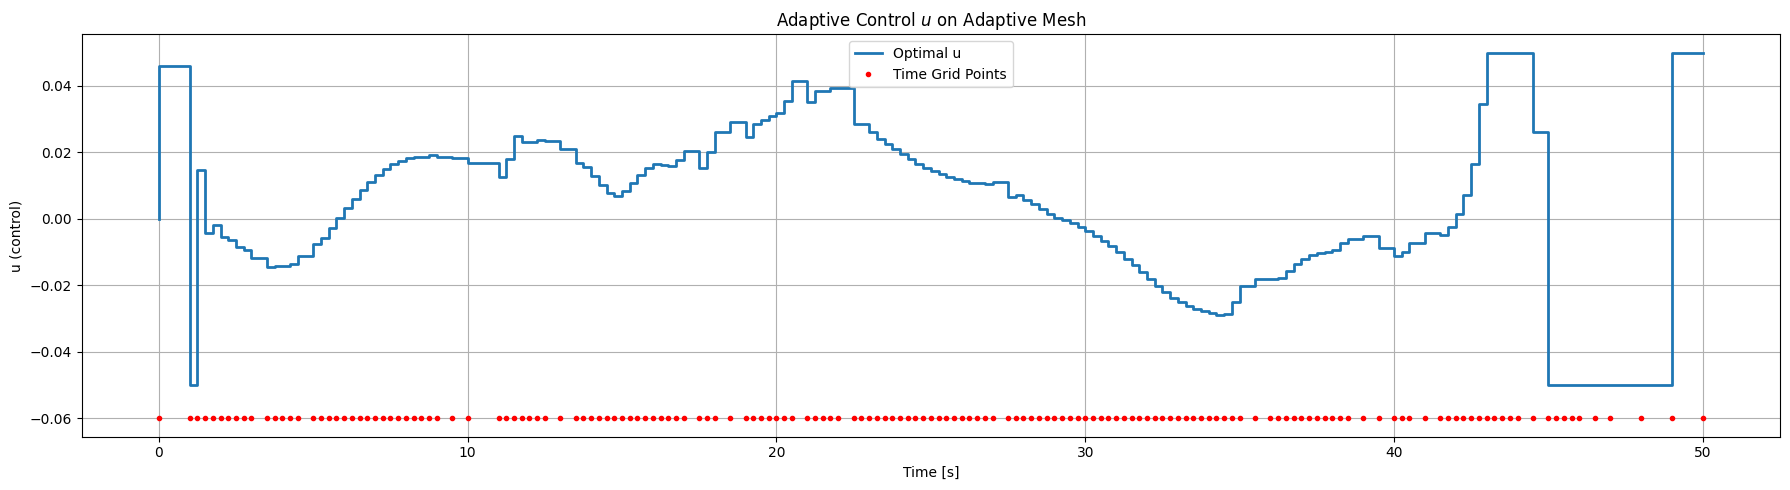

In [6]:
time_grid = res["time_grid"]
u = res["u"]  # shape: (N,)

plt.figure(figsize=(18, 5))
plt.step(time_grid, u, label='Optimal u', linewidth=2)
plt.plot(time_grid, -0.06*np.ones_like(time_grid), 'r.', label='Time Grid Points')
plt.xlabel('Time [s]')
plt.ylabel('u (control)')
plt.title('Adaptive Control $u$ on Adaptive Mesh')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [7]:
res_no_sc = solve_wider_wind_ocp_pce(tf = 50, N = 100, pce_order=2, k_mean=1.0, k_std=0.08, s_mean=1.0, s_std=0.15)

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  10.21ms (200.14us)  10.22ms (200.32us)        51
       nlp_g  | 489.57ms (  9.60ms) 489.85ms (  9.60ms)        51
  nlp_grad_f  |  18.90ms (370.63us)  18.88ms (370.16us)        51
   nlp_jac_g  |   2.41 s ( 47.18ms)   2.49 s ( 48.78ms)        51
       total  |   5.00 s (  5.00 s)   5.08 s (  5.08 s)         1


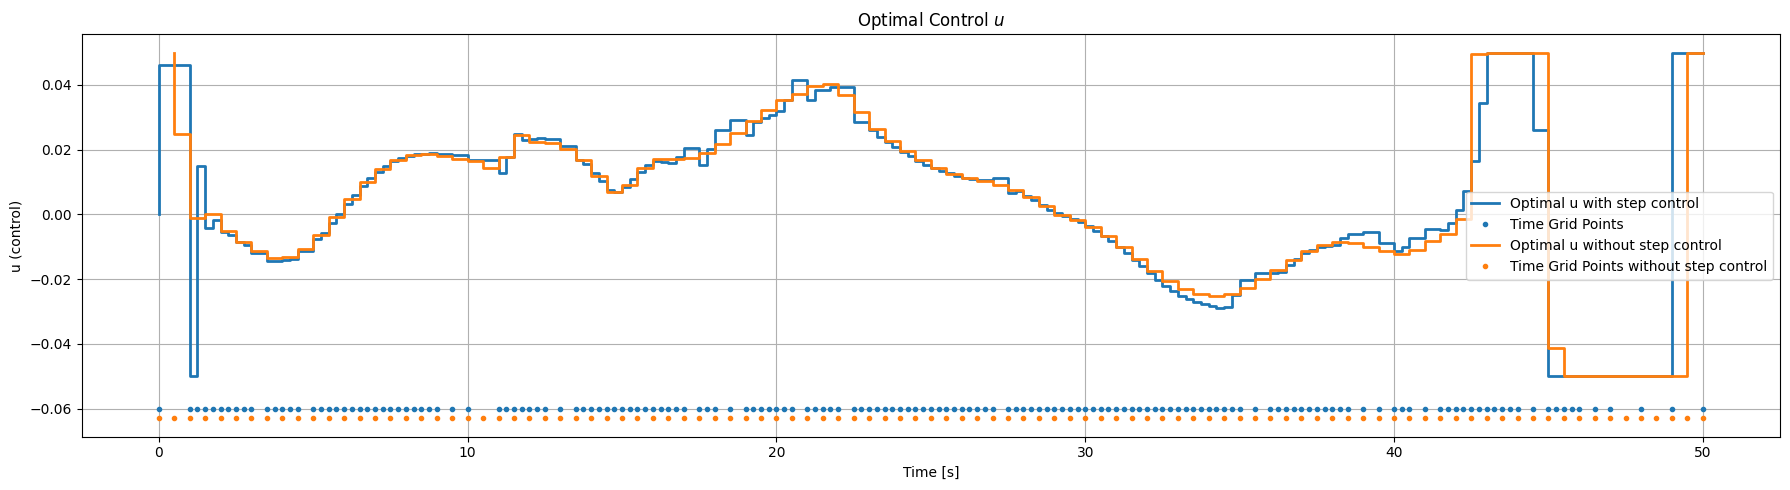

In [8]:
plt.figure(figsize=(18, 5))
plt.step(res["time_grid"], res["u"], label='Optimal u with step control', linewidth=2)
plt.plot(res["time_grid"], -0.06*np.ones_like(res["time_grid"]), '.', color='tab:blue', label='Time Grid Points')
plt.step(res_no_sc["time_grid"][1:], res_no_sc["u"], label='Optimal u without step control', linewidth=2)
plt.plot(res_no_sc["time_grid"], -0.063*np.ones_like(res_no_sc["time_grid"]), '.', color='tab:orange', label='Time Grid Points without step control')
plt.xlabel('Time [s]')
plt.ylabel('u (control)')
plt.title('Optimal Control $u$')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [9]:
colors = {
    "safe": "#2c7bb6",      # Dark Blue
    "low": "#abd9e9",       # Light Blue
    "very_low": "#fdae61",  # Orange
    "crash": "#d7191c"      # Red
}

# Physical constants
m = 4662
g = 32.172
delta = 0.03491
A0 = 0.4456e5
A1 = -0.2398e2
A2 = 0.1442e-1
rho = 0.2203e-2
S = 0.1560e4
beta0 = 0.4
beta_dot0 = 0.2
sigma = 3
B0 = 0.1552
B1 = 0.12369
B2 = 2.4203
C0 = 0.7125
C1 = 6.0877
C2 = -9.0277
alpha_star = 0.20944
a = 6e-8
b = -4e-11
c = -np.log(25/30.6)*1e-12
d = -8.02881e-8
e = 6.28083e-11
h_star = 1000
eps = 1e-6

# Wind model functions
def Smooth(x_, x0, x1):
    t = (x_ - x0) / (x1 - x0 + eps)
    return ca.if_else(x_ < x0, 0,
           ca.if_else(x_ > x1, 1, 6*t**5 - 15*t**4 + 10*t**3))

def A_piecewise(x_, s_):
    A1 = -50 + a * (x_/s_)**3 + b * (x_/s_)**4
    A2 = 0.025 * ((x_/s_) - 2300)
    A3 = 50 - a * (4600 - (x_/s_))**3 - b * (4600 - (x_/s_))**4
    A4 = 50
    s1 = Smooth(x_, 480 * s_, 520 * s_)
    s2 = Smooth(x_, 4080 * s_, 4120 * s_)
    s3 = Smooth(x_, 4580 * s_, 4620 * s_)
    B12 = (1 - s1)*A1 + s1*A2
    B23 = (1 - s2)*A2 + s2*A3
    B34 = (1 - s3)*A3 + s3*A4
    return ca.if_else(x_ <= 500 * s_, B12,
            ca.if_else(x_ <= 4100 * s_, B23,
            ca.if_else(x_ <= 4600 * s_, B34, A4)))

def B_piecewise(x_, s_):
    B1 = d * (x_/s_)**3 + e * (x_/s_)**4
    B2 = -51 * ca.exp(ca.fmin(-c * ((x_/s_) - 2300)**4, 30))
    B3 = d * (4600 - (x_/s_))**3 + e * (4600 - (x_/s_))**4
    B4 = 0
    s1 = Smooth(x_, 480 * s_, 520 * s_)
    s2 = Smooth(x_, 4080 * s_, 4120 * s_)
    s3 = Smooth(x_, 4580 * s_, 4620 * s_)
    B12 = (1 - s1)*B1 + s1*B2
    B23 = (1 - s2)*B2 + s2*B3
    B34 = (1 - s3)*B3 + s3*B4
    return ca.if_else(x_ <= 500 * s_, B12,
            ca.if_else(x_ <= 4100 * s_, B23,
            ca.if_else(x_ <= 4600 * s_, B34, B4)))

def wind_x(x_, k_, s_):
    return k_ * A_piecewise(x_, s_)

def wind_h(x_, h_, k_, s_):
    h_safe = ca.fmax(h_, 10.0)
    return k_ * h_safe / h_star * B_piecewise(x_, s_)

def originalWindModel(x_, h_, k_, s_):
    return wind_x(x_, k_, s_), wind_h(x_, h_, k_, s_)

def C_L(alpha_):
    return ca.if_else(alpha_ > alpha_star, C0 + C1 * alpha_,
                      C0 + C1 * alpha_ + C2 * (alpha_ - alpha_star)**2)
def beta(t_):
    return ca.if_else(t_ < sigma, beta0 + beta_dot0 * t_, 1.0)

def aircraft_ode(k_value):
    s_value = (1.0 / k_value) ** 2
    x_ = ca.MX.sym('x')
    h_ = ca.MX.sym('h')
    V_ = ca.MX.sym('V')
    gamma_ = ca.MX.sym('gamma')
    alpha_ = ca.MX.sym('alpha')

    u_ = ca.MX.sym('u')
    t_ = ca.MX.sym('t')

    T = beta(t_) * (A0 + A1 * V_ + A2 * V_**2)
    D = 0.5 * (B0 + B1 * alpha_ + B2 * alpha_**2) * rho * S * V_**2
    L = 0.5 * rho * S * C_L(alpha_) * V_**2

    Wx, Wh = originalWindModel(x_, h_, k_value, s_value)
    dWx_dx_fun = ca.Function("dWx_dx", [x_], [ca.gradient(Wx, x_)])
    dWh_dx_fun = ca.Function("dWh_dx", [x_, h_], [ca.gradient(Wh, x_)])
    dWh_dh_fun = ca.Function("dWh_dh", [x_, h_], [ca.gradient(Wh, h_)])

    V_safe = ca.fmax(V_, 1e-3)

    x_dot = V_ * ca.cos(gamma_) + Wx
    h_dot = V_ * ca.sin(gamma_) + Wh

    dWx_dx_val = dWx_dx_fun(x_)[0]
    dWh_dx_val = dWh_dx_fun(x_, h_)[0]
    dWh_dh_val = dWh_dh_fun(x_, h_)[0]

    Wx_dot = dWx_dx_val * x_dot
    Wh_dot = dWh_dx_val * x_dot + dWh_dh_val * h_dot

    V_dot = (
        T / m * ca.cos(alpha_ + delta)
        - D / m
        - g * ca.sin(gamma_)
        - (Wx_dot * ca.cos(gamma_) + Wh_dot * ca.sin(gamma_))
    )
    gamma_dot = (
        T / (m * V_safe) * ca.sin(alpha_ + delta)
        + L / (m * V_safe)
        - g / V_safe * ca.cos(gamma_)
        + (1 / V_safe) * (Wx_dot * ca.sin(gamma_) - Wh_dot * ca.cos(gamma_))
    )
    alpha_dot = u_

    y0 = ca.vertcat(x_, h_, V_, gamma_, alpha_)
    yk = ca.vertcat(x_dot, h_dot, V_dot, gamma_dot, alpha_dot)
    return ca.Function('f', [y0, u_, t_], [yk])

def rk4_step(f, xk, uk, tk, dt):
    k1 = f(xk, uk, tk)
    k2 = f(xk + dt/2 * k1, uk, tk + dt/2)
    k3 = f(xk + dt/2 * k2, uk, tk + dt/2)
    k4 = f(xk + dt * k3, uk, tk + dt)
    return xk + dt/6 * (k1 + 2*k2 + 2*k3 + k4)

def reconstruct_trajectory(u_opt, time_grid, k, x0=0, h0=600, V0=239.7, gamma0=-0.03925, alpha0=0.1283):
    traj = {"x": [], "h": [], "V": [], "gamma": [], "alpha": [], "t": []}
    X = np.array([x0, h0, V0, gamma0, alpha0])

    f = aircraft_ode(k)

    dt_ls = np.diff(time_grid)
    for i, u in enumerate(u_opt):
        t = time_grid[i]
        dt = dt_ls[i]
        traj["x"].append(float(X[0]))
        traj["h"].append(float(X[1]))
        traj["V"].append(float(X[2]))
        traj["gamma"].append(float(X[3]))
        traj["alpha"].append(float(X[4]))
        traj["t"].append(t)
        X = rk4_step(f, X, u, t, dt)

    traj["x"].append(float(X[0]))
    traj["h"].append(float(X[1]))
    traj["V"].append(float(X[2]))
    traj["gamma"].append(float(X[3]))
    traj["alpha"].append(float(X[4]))
    traj["t"].append(t + dt)
    return traj

def visualize_trajectory(u_opt, time_grid):
    k_values = np.random.normal(1.0, 0.08, 10000)

    under_0, under_50, under_100 = 0, 0, 0

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    for k in k_values:
        traj = reconstruct_trajectory(u_opt, time_grid, k)

        if min(traj["h"]) < 1e-6:
            under_0 += 1
            print(k)
            ax1.plot(traj["x"], traj["h"], alpha=0.3, color=colors["crash"])
            ax2.plot(time_grid, traj["V"], alpha=0.3, color=colors["crash"])
        elif min(traj["h"]) < 50:
            under_50 += 1
            ax1.plot(traj["x"], traj["h"], alpha=0.3, color=colors["very_low"])
            ax2.plot(time_grid, traj["V"], alpha=0.3, color=colors["very_low"])
        elif min(traj["h"]) < 100:
            under_100 += 1
            ax1.plot(traj["x"], traj["h"], alpha=0.3, color=colors["low"])
            ax2.plot(time_grid, traj["V"], alpha=0.3, color=colors["low"])
        else:
            ax1.plot(traj["x"], traj["h"], alpha=0.3, color=colors["safe"])
            ax2.plot(time_grid, traj["V"], alpha=0.3, color=colors["safe"])

    ax1.set_xlabel("x [ft]")
    ax1.set_ylabel("h [ft]")
    ax1.set_title("Trajectory (x vs h)")
    ax1.grid(True)
    legend_elements = [
        Line2D([0], [0], color=colors["safe"],      lw=2, label='Safe (h ≥ 100 ft)'),
        Line2D([0], [0], color=colors["low"],       lw=2, label='Low (50 ≤ h < 100 ft)'),
        Line2D([0], [0], color=colors["very_low"],  lw=2, label='Very low (0 ≤ h < 50 ft)'),
        Line2D([0], [0], color=colors["crash"],     lw=2, label='Crash (h ≤ 0)')
    ]
    ax1.legend(handles=legend_elements, loc='upper left', title="Min Altitude Zones")

    ax2.set_xlabel("t [sec]")
    ax2.set_ylabel("V [ft/s]")
    ax2.set_title("Velocity (V vs x)")
    ax2.grid(True)
    # ax2.legend()

    plt.tight_layout()
    plt.show()

    print(f"P(Under 100) = {(under_100+under_50+under_0)/len(k_values):.4f}")
    print(f"P(Under 50) = {(under_50+under_0)/len(k_values):.4f}")
    print(f"P(Under 0) = {under_0/len(k_values):.4f}")

1.2830738033621005
1.2912641512374339
1.296741829854981
1.2882121257040746
1.2936380484839218
1.306971738675763


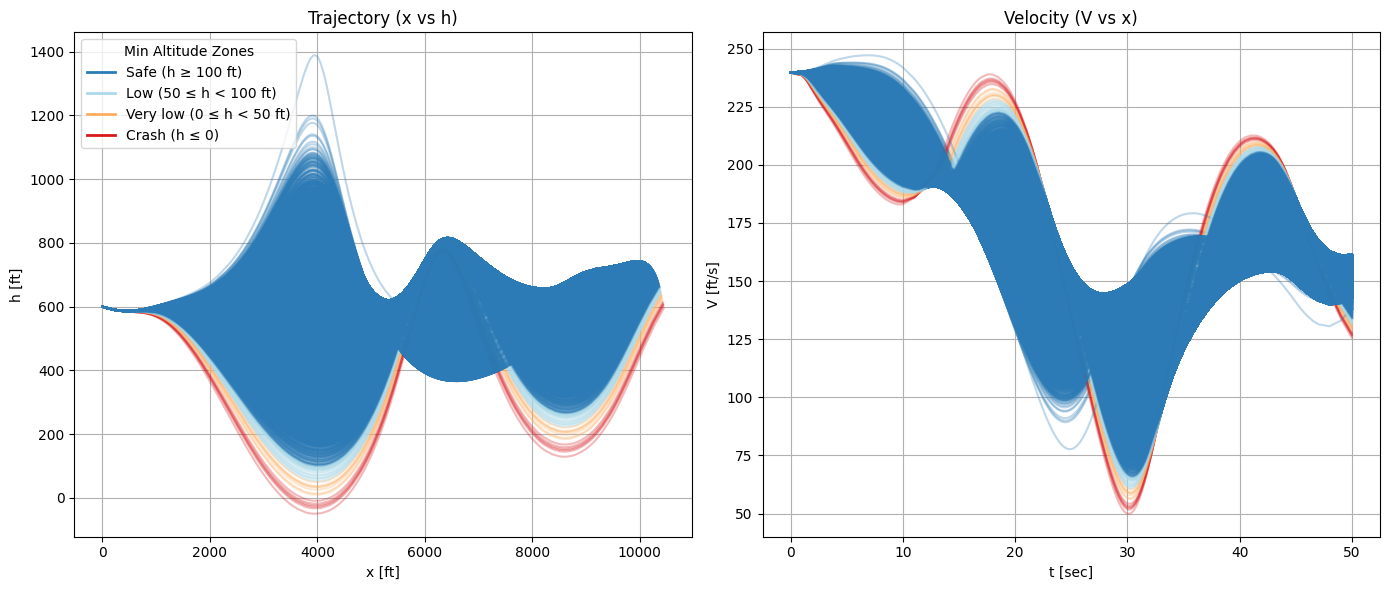

P(Under 100) = 0.0038
P(Under 50) = 0.0013
P(Under 0) = 0.0006


In [10]:
visualize_trajectory(res["u"][1:], res["time_grid"])

1.285664618510668
1.3553896852839529
1.2852273654789597


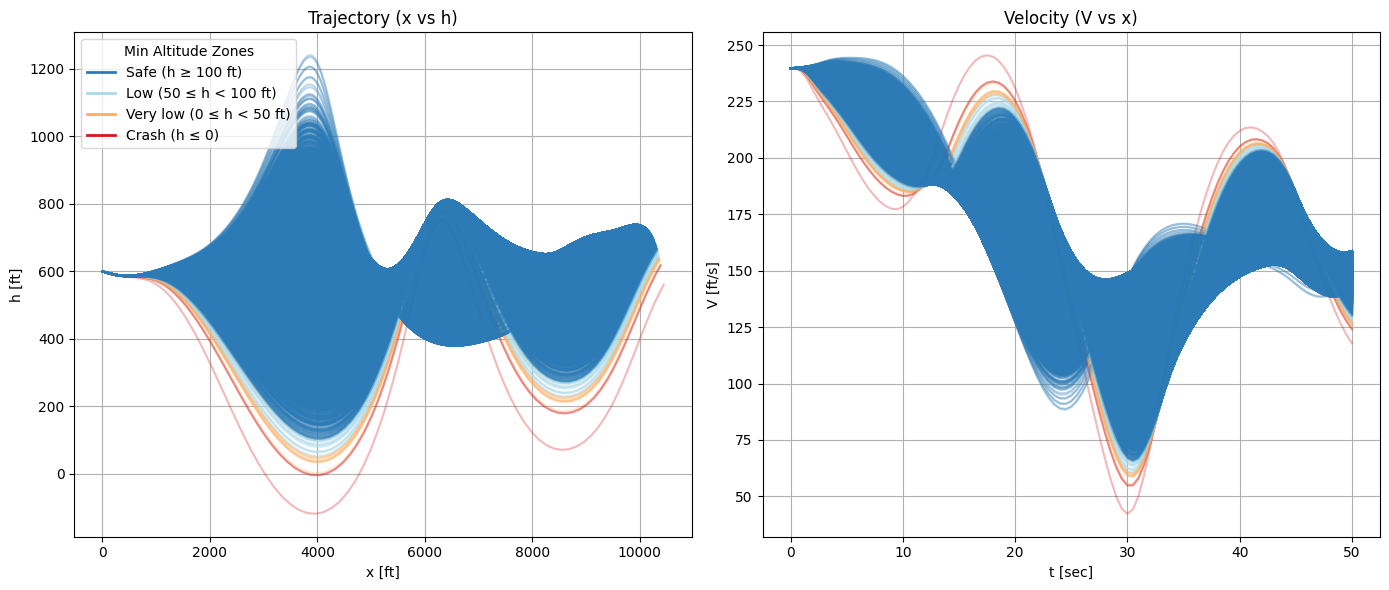

P(Under 100) = 0.0028
P(Under 50) = 0.0011
P(Under 0) = 0.0003


In [11]:
visualize_trajectory(res_no_sc["u"], res_no_sc["time_grid"])

In [22]:
def solve_wider_wind_ocp_pce_w_adaptive_mesh_q(pce_order, k_mean, k_std, du_tol=1e-3, max_iter=3):
    
    def refine_time_grid(u_guess, time_grid, du_tol=0.1):
        refined = False
        u_guess = np.asarray(u_guess)
        time_grid = np.asarray(time_grid)
        du = np.abs(np.diff(np.insert(u_guess, 0, u_guess[0])))
        refined_time_grid = [time_grid[0]]  # Start with the first time point
        for i in range(1, len(du)):
            if du[i-1] > du_tol:
                refined = True
                t_mid = (time_grid[i-1] + time_grid[i]) / 2
                refined_time_grid.append(t_mid)
            refined_time_grid.append(time_grid[i])
        refined_time_grid.append(time_grid[-1])  # Ensure the last time point is included
        return refined, np.unique(refined_time_grid)
    
    # Time and discretization
    tf = 50        # final time [sec]
    N = 50         # number of control intervals
    # dt = tf / N    # time step
    time_grid = np.linspace(0, tf, N+1)  # time grid for adaptive mesh

    # Aircraft physical constants
    m = 4662                # mass [lb sec^2 / ft]
    g = 32.172              # gravity [ft/sec^2]
    delta = 0.03491         # thrust inclination angle [rad]

    # Thrust model coefficients: T = A0 + A1*V + A2*V^2
    A0 = 0.4456e5           # [lb]
    A1 = -0.2398e2          # [lb sec / ft]
    A2 = 0.1442e-1          # [lb sec^2 / ft^2]

    # Aerodynamic model
    rho = 0.2203e-2         # air density [lb sec^2 / ft^4]
    S = 0.1560e4            # reference surface area [ft^2]

    # Wind model 3 beta (smoothing) parameters
    beta0 = 0.4             # initial beta value (approximate)
    beta_dot0 = 0.2         # initial beta rate
    sigma = 3               # time to reach beta = 1 [sec]

    # C_D(alpha) = B0 + B1 * alpha + B2 * alpha**2, D = 0.5 * C_D(α) * ρ * S * V²
    B0 = 0.1552
    B1 = 0.12369            # [1/rad]
    B2 = 2.4203             # [1/rad^2]

    # Lift coefficient: C_L = C0 + C1 * alpha (+ C2 * alpha**2)
    C0 = 0.7125             # baseline lift coefficient
    C1 = 6.0877             # AOA lift slope [1/rad]

    # Lift/drag model optional extensions (if needed)
    C2 = -9.0277            # [rad^-2] — e.g., for moment or drag extension

    # Angle of attack & control constraints
    umax = 0.05236          # max control input (rate of change of alpha) [rad/sec]
    alphamax = 0.3          # max angle of attack [rad]
    alpha_star = 0.20944    # changing pt of AoA

    # Wind model x parameters (piecewise smooth wind)
    a = 6e-8                 # x transition midpoint [ft]
    b = -4e-11               # second transition point [ft]

    # Wind model h parameters (polynomial form)
    c = -np.log(25/30.6)*1e-12      # transition smoothing width [ft]
    d = -8.02881e-8         # polynomial coeff [sec^-1 ft^-2]
    e = 6.28083e-11         # polynomial coeff [sec^-1 ft^-3]

    # Cost function / target altitude
    hR = 1000               # reference altitude [ft]
    h_star = 1000           # used in some wind models

    # Auxiliary
    eps = 1e-6              # to avoid division by zero in V

    # Scaling factors (used if normalizing states)
    xscale = 10000          # [ft]
    hscale = 1000           # [ft]
    Vscale = 240            # [ft/sec]
    gammascale = 0.1        # [rad]
    alphascale = 0.3        # [rad]
    uscale = 0.05           # [rad/sec]

    # PCE parameters
    # k_dist = cp.Normal(k_mean, k_std)
    # s_dist = cp.Normal(0.0, 1.0)
    k_dist = cp.Uniform(k_mean - 3*k_std, k_mean + 3*k_std)
    s_dist = cp.Uniform(1.0 - 3*0.15, 1.0 + 3*0.15)
    joint_dist = cp.J(k_dist, s_dist)
    
    poly_basis = cp.expansion.stieltjes(pce_order, joint_dist)
    nodes, weights = cp.generate_quadrature(pce_order, joint_dist, rule='G')
    # print(poly_basis.shape)     # ((pce_order+1)(pce_order+2)/2, )
    # print(weights.shape)        # ((pce_order+1)^2, )
    # print(nodes.shape)          # (2, (pce_order+1)^2)
    print(poly_basis)
    
    M = nodes.shape[1]              # number of PCE samples
    
    weights_dm = ca.DM(weights)   # ((pce_order+1)^2， )
    
    Psi_mat = poly_basis(*nodes)    # (M_poly_basis, (pce_order+1)^2)
    Psi_dm = ca.DM(Psi_mat)         # (M_poly_basis, (pce_order+1)^2)

    def Smooth(x_, x0, x1):
        t = (x_ - x0) / (x1 - x0 + eps)
        return ca.if_else(x_ < x0, 0,
               ca.if_else(x_ > x1, 1, 6*t**5 - 15*t**4 + 10*t**3))

    def A_piecewise(x_, s_):
        A1 = -50 + a * (x_/s_)**3 + b * (x_/s_)**4
        A2 = 0.025 * ((x_/s_) - 2300)
        A3 = 50 - a * (4600 - (x_/s_))**3 - b * (4600 - (x_/s_))**4
        A4 = 50
        s1 = Smooth(x_, 480 * s_, 520 * s_)
        s2 = Smooth(x_, 4080 * s_, 4120 * s_)
        s3 = Smooth(x_, 4580 * s_, 4620 * s_)
        B12 = (1 - s1)*A1 + s1*A2
        B23 = (1 - s2)*A2 + s2*A3
        B34 = (1 - s3)*A3 + s3*A4
        return ca.if_else(x_ <= 500 * s_, B12,
               ca.if_else(x_ <= 4100 * s_, B23,
               ca.if_else(x_ <= 4600 * s_, B34, A4)))

    def B_piecewise(x_, s_):
        B1 = d * (x_/s_)**3 + e * (x_/s_)**4
        B2 = -51 * ca.exp(ca.fmin(-c * ((x_/s_) - 2300)**4, 30))
        B3 = d * (4600 - (x_/s_))**3 + e * (4600 - (x_/s_))**4
        B4 = 0
        s1 = Smooth(x_, 480 * s_, 520 * s_)
        s2 = Smooth(x_, 4080 * s_, 4120 * s_)
        s3 = Smooth(x_, 4580 * s_, 4620 * s_)
        B12 = (1 - s1)*B1 + s1*B2
        B23 = (1 - s2)*B2 + s2*B3
        B34 = (1 - s3)*B3 + s3*B4
        return ca.if_else(x_ <= 500 * s_, B12,
               ca.if_else(x_ <= 4100 * s_, B23,
               ca.if_else(x_ <= 4600 * s_, B34, B4)))

    def wind_x(x_, k_, s_):
        return k_ * A_piecewise(x_, s_)

    def wind_h(x_, h_, k_, s_):
        h_safe = ca.fmax(h_, 10.0)
        return k_ * h_safe / h_star * B_piecewise(x_, s_)

    def C_L(alpha_):
        return ca.if_else(alpha_ > alpha_star, C0 + C1 * alpha_,
                          C0 + C1 * alpha_ + C2 * (alpha_ - alpha_star)**2)
    def beta(t_):
        return ca.if_else(t_ < sigma, beta0 + beta_dot0 * t_, 1.0)

    def rk4_step(f, xk, uk, tk, dt, k_val, s_val):
        k1 = f(xk, uk, tk, k_val, s_val)
        k2 = f(xk + dt/2 * k1, uk, tk + dt/2, k_val, s_val)
        k3 = f(xk + dt/2 * k2, uk, tk + dt/2, k_val, s_val)
        k4 = f(xk + dt * k3, uk, tk + dt, k_val, s_val)
        return xk + dt/6 * (k1 + 2*k2 + 2*k3 + k4)
    
    def solve_ocp(time_grid):
        N = len(time_grid)
        dt_list = np.diff(time_grid)  # Calculate time steps from the time grid
        
        # Opti instance and scaled variables
        opti = ca.Opti()
        x_s = opti.variable(M, N+1)
        h_s = opti.variable(M, N+1)
        V_s = opti.variable(M, N+1)
        gamma_s = opti.variable(M, N+1)
        alpha_s = opti.variable(M, N+1)
        X_pce = opti.variable(5*(pce_order+1), N+1)
        u_s = opti.variable(N)

        # Unscaled variables for dynamics
        x = x_s * xscale
        h = h_s * hscale
        V = V_s * Vscale
        gamma = gamma_s * gammascale
        alpha = alpha_s * alphascale
        u = u_s * uscale

        # Symbolic derivatives
        x_sym = ca.MX.sym("x")
        h_sym = ca.MX.sym("h")
        k_sym = ca.MX.sym("k")
        s_sym = ca.MX.sym("s")
        Wx_expr = wind_x(x_sym, k_sym, s_sym)
        Wh_expr = wind_h(x_sym, h_sym, k_sym, s_sym)
        dWx_dx_fun = ca.Function("dWx_dx", [x_sym, k_sym, s_sym], [ca.gradient(Wx_expr, x_sym)])
        dWh_dx_fun = ca.Function("dWh_dx", [x_sym, h_sym, k_sym, s_sym], [ca.gradient(Wh_expr, x_sym)])
        dWh_dh_fun = ca.Function("dWh_dh", [x_sym, h_sym, k_sym, s_sym], [ca.gradient(Wh_expr, h_sym)])
        
        def aircraft_ode(X, u_, t_, k_val, s_val):
            x_, h_, V_, gamma_, alpha_ = ca.vertsplit(X)

            T = beta(t_) * (A0 + A1 * V_ + A2 * V_**2)
            D = 0.5 * (B0 + B1 * alpha_ + B2 * alpha_**2) * rho * S * V_**2
            L = 0.5 * rho * S * C_L(alpha_) * V_**2

            Wx = wind_x(x_, k_val, s_val)
            Wh = wind_h(x_, h_, k_val, s_val)
            V_safe = ca.fmax(V_, 1e-3)

            x_dot = V_ * ca.cos(gamma_) + Wx
            h_dot = V_ * ca.sin(gamma_) + Wh

            dWx_dx_val = dWx_dx_fun(x_, k_val, s_val)[0]
            dWh_dx_val = dWh_dx_fun(x_, h_, k_val, s_val)[0]
            dWh_dh_val = dWh_dh_fun(x_, h_, k_val, s_val)[0]

            Wx_dot = dWx_dx_val * x_dot
            Wh_dot = dWh_dx_val * x_dot + dWh_dh_val * h_dot

            V_dot = T / m * ca.cos(alpha_ + delta) - D / m - g * ca.sin(gamma_) - (Wx_dot * ca.cos(gamma_) + Wh_dot * ca.sin(gamma_))
            gamma_dot = T / (m * V_safe) * ca.sin(alpha_ + delta) + L / (m * V_safe) - g / V_safe * ca.cos(gamma_) + (1 / V_safe) * (Wx_dot * ca.sin(gamma_) - Wh_dot * ca.cos(gamma_))
            alpha_dot = u_

            return ca.vertcat(x_dot, h_dot, V_dot, gamma_dot, alpha_dot)

        J = 0

        # Initial conditions
        opti.subject_to(x_s[:, 0] == 0)
        opti.subject_to(h_s[:, 0] == 600 / hscale)
        opti.subject_to(V_s[:, 0] == 239.7 / Vscale)
        opti.subject_to(gamma_s[:, 0] == -0.03925 / gammascale)
        opti.subject_to(alpha_s[:, 0] == 0.1283 / alphascale)
        opti.subject_to(ca.vec(V_s) >= 1e-2 / Vscale)
        # opti.subject_to(gamma_s[:, -1] == -0.05236 / gammascale)
        opti.subject_to(gamma_s[:, -1] >= 0)
        
        h_ddot_all = [[] for _ in range(N)]
        
        for j in range(M):
            k_val, s_val = nodes[:, j]
            
            i = 0
            dt = 0
            tk = time_grid[i]  # Current time from the time grid
                
            h_physical = h_s[:, i] * hscale
            h_mean = ca.dot(weights_dm, h_physical)

            h_pce_coeffs = ca.mtimes(Psi_dm, weights_dm * h_physical)
            h_high_coeffs = h_pce_coeffs[1:]
            h_std_term = ca.sqrt(ca.sumsqr(h_high_coeffs))

            deviation = hR - h_mean + h_std_term * 12
            scaled_deviation = deviation / hscale
            J += dt * scaled_deviation**6

            Xk = ca.vertcat(x[j, i], h[j, i], V[j, i], gamma[j, i], alpha[j, i])
            Uk = u[i]
            
            # h_ddot = d^2h/dt^2 = V_dot * sin(gamma) + V * cos(gamma) * gamma_dot + Wh_dot
            ode_out = aircraft_ode(Xk, Uk, tk, k_val, s_val)
            x_dot_k = ode_out[0]
            h_dot_k = ode_out[1]
            V_dot_k = ode_out[2]
            gamma_dot_k = ode_out[3]
            # alpha_dot_k = ode_out[4]
            
            dWh_dx_val = dWh_dx_fun(Xk[0], Xk[1], k_val, s_val)[0]
            dWh_dh_val = dWh_dh_fun(Xk[0], Xk[1], k_val, s_val)[0]
            Wh_dot_k = dWh_dx_val * x_dot_k + dWh_dh_val * h_dot_k
            
            h_ddot_k = V_dot_k * ca.sin(Xk[3]) + Xk[2] * ca.cos(Xk[3]) * gamma_dot_k + Wh_dot_k
            
            h_ddot_all[i].append(h_ddot_k)
            
            Xk_end = rk4_step(aircraft_ode, Xk, Uk, tk, dt, k_val, s_val)
            X_next = ca.vertcat(x[j, i+1], h[j, i+1], V[j, i+1], gamma[j, i+1], alpha[j, i+1])
            opti.subject_to(X_next == Xk_end)

            opti.subject_to(opti.bounded(-1, u_s[i], 1))

            alpha_i = alpha_s[:, i] * alphascale
            alpha_pce_coeffs = ca.mtimes(Psi_dm, weights_dm * alpha_i)
            alpha_high_coeffs = alpha_pce_coeffs[1:]
            alpha_mean = ca.dot(weights_dm, alpha_i)
            std_term = ca.sqrt(ca.sumsqr(alpha_high_coeffs))
            
            for i in range(1, N):
                dt = dt_list[i-1]  # Use the time step from the time grid
                tk = time_grid[i]  # Current time from the time grid
                
                h_physical = h_s[:, i] * hscale
                h_mean = ca.dot(weights_dm, h_physical)

                h_pce_coeffs = ca.mtimes(Psi_dm, weights_dm * h_physical)
                h_high_coeffs = h_pce_coeffs[1:]
                h_std_term = ca.sqrt(ca.sumsqr(h_high_coeffs))

                deviation = hR - h_mean + h_std_term * 12
                scaled_deviation = deviation / hscale
                J += dt * scaled_deviation**6

                Xk = ca.vertcat(x[j, i], h[j, i], V[j, i], gamma[j, i], alpha[j, i])
                Uk = u[i]
                
                # h_ddot = d^2h/dt^2 = V_dot * sin(gamma) + V * cos(gamma) * gamma_dot + Wh_dot
                ode_out = aircraft_ode(Xk, Uk, tk, k_val, s_val)
                x_dot_k = ode_out[0]
                h_dot_k = ode_out[1]
                V_dot_k = ode_out[2]
                gamma_dot_k = ode_out[3]
                # alpha_dot_k = ode_out[4]
                
                dWh_dx_val = dWh_dx_fun(Xk[0], Xk[1], k_val, s_val)[0]
                dWh_dh_val = dWh_dh_fun(Xk[0], Xk[1], k_val, s_val)[0]
                Wh_dot_k = dWh_dx_val * x_dot_k + dWh_dh_val * h_dot_k
                
                h_ddot_k = V_dot_k * ca.sin(Xk[3]) + Xk[2] * ca.cos(Xk[3]) * gamma_dot_k + Wh_dot_k
                
                h_ddot_all[i].append(h_ddot_k)
                
                Xk_end = rk4_step(aircraft_ode, Xk, Uk, tk, dt, k_val, s_val)
                X_next = ca.vertcat(x[j, i+1], h[j, i+1], V[j, i+1], gamma[j, i+1], alpha[j, i+1])
                opti.subject_to(X_next == Xk_end)

                opti.subject_to(opti.bounded(-1, u_s[i], 1))

                alpha_i = alpha_s[:, i] * alphascale
                alpha_pce_coeffs = ca.mtimes(Psi_dm, weights_dm * alpha_i)
                alpha_high_coeffs = alpha_pce_coeffs[1:]
                alpha_mean = ca.dot(weights_dm, alpha_i)
                std_term = ca.sqrt(ca.sumsqr(alpha_high_coeffs))

            opti.subject_to(alpha_mean + 3 * std_term <= alphamax)
            opti.subject_to(alpha_mean - 3 * std_term >= -alphamax)
                
        for i in range(N):
            h_ddot_vec = ca.vertcat(*h_ddot_all[i])
            h_ddot_pce_coeffs = ca.mtimes(Psi_dm, weights_dm * h_ddot_vec)
            h_ddot_mean = h_ddot_pce_coeffs[0]
            h_ddot_high_coeffs = h_ddot_pce_coeffs[1:]
            h_ddot_std_term = ca.sqrt(ca.sumsqr(h_ddot_high_coeffs))
            
            opti.subject_to(h_ddot_mean + 3 * h_ddot_std_term <= 10 * g)
            opti.subject_to(h_ddot_mean - 3 * h_ddot_std_term >= -2 * g)

        opti.minimize(J)

        # Initial guess
        for j in range(M):
            opti.set_initial(x_s[j, :], np.linspace(0, 1, N+1))
            opti.set_initial(h_s[j, :], 0.6)  # 600 ft / 1000
            opti.set_initial(V_s[j, :], 239.7 / Vscale)
            opti.set_initial(gamma_s[j, :], -0.01 / gammascale)
            opti.set_initial(alpha_s[j, :], 0.02 / alphascale)
        opti.set_initial(u_s, 0)

        # Solver
        opts = {
            "expand": True,
            "ipopt": {
                # "max_iter": 3000,
                "max_cpu_time": 120,
                "tol": 1e-6,
                "print_level": 0,
                "linear_solver": "mumps",
                "hessian_approximation": "limited-memory",
                # "bound_push": 1e-8,
                # "bound_frac": 1e-8
            }
        }
        opti.solver("ipopt", opts)

        try:
            sol = opti.solve()
        except RuntimeError as e:
            opti.debug.show_infeasibilities()
            print(e)
            return {
                "x": opti.debug.value(x),
                "h": opti.debug.value(h),
                "V": opti.debug.value(V),
                "gamma": opti.debug.value(gamma),
                "alpha": opti.debug.value(alpha),
                "u": opti.debug.value(u),
                "J": opti.debug.value(J),
                "time_grid": time_grid,
                "dt_list": dt_list,
                "status": "failed"
            }

        return {
            "x": sol.value(x),
            "h": sol.value(h),
            "V": sol.value(V),
            "gamma": sol.value(gamma),
            "alpha": sol.value(alpha),
            "u": sol.value(u),
            "J": sol.value(J),
            "time_grid": time_grid,
            "dt_list": dt_list,
            "status": "success"
        }

    def solve_and_refine(time_grid, max_iter=3):
        refined = True
        iter_count = 0
        while refined and iter_count < max_iter:
            sol = solve_ocp(time_grid)
            
            # Check if further refinement is needed
            refined, new_time_grid = refine_time_grid(sol["u"], time_grid, du_tol)
            if refined:
                time_grid = new_time_grid
                iter_count += 1
                print(f"Refining time grid, iteration {iter_count}")
            else:
                break
    
        return sol
    
    return solve_and_refine(time_grid, max_iter=max_iter)

In [23]:
res_q = solve_wider_wind_ocp_pce_w_adaptive_mesh_q(pce_order=2, k_mean=1.0, k_std=0.08, du_tol=0.01, max_iter=3)

[1.0 q1-1.0 q0-1.0 q1**2-2.0*q1+0.9325 q0*q1-q1-q0+1.0 q0**2-2.0*q0+0.9808]
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   5.64ms (106.51us)   5.63ms (106.26us)        53
       nlp_g  | 265.91ms (  5.02ms) 265.97ms (  5.02ms)        53
  nlp_grad_f  |  10.01ms (196.31us)  10.02ms (196.44us)        51
   nlp_jac_g  |   1.22 s ( 23.85ms)   1.22 s ( 23.86ms)        51
       total  |   2.73 s (  2.73 s)   2.75 s (  2.75 s)         1
Refining time grid, iteration 1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  11.46ms (163.70us)  11.44ms (163.47us)        70
       nlp_g  | 510.75ms (  7.30ms) 510.95ms (  7.30ms)        70
  nlp_grad_f  |  18.58ms (290.28us)  18.57ms (290.22us)        64
   nlp_jac_g  |   2.24 s ( 34.93ms)   2.24 s ( 34.95ms)        64
       total  |   4.87 s (  4.87 s)   4.87 s (  4.87 s)         1
Refining time grid, iteration 2
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
  

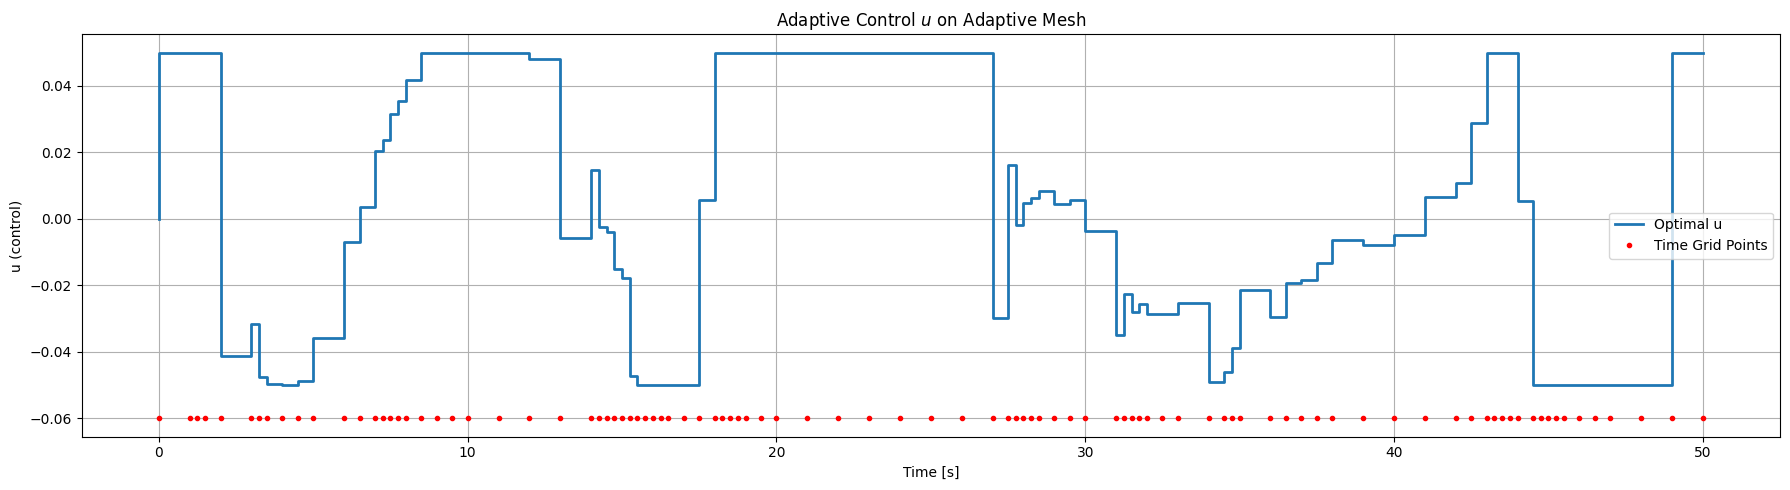

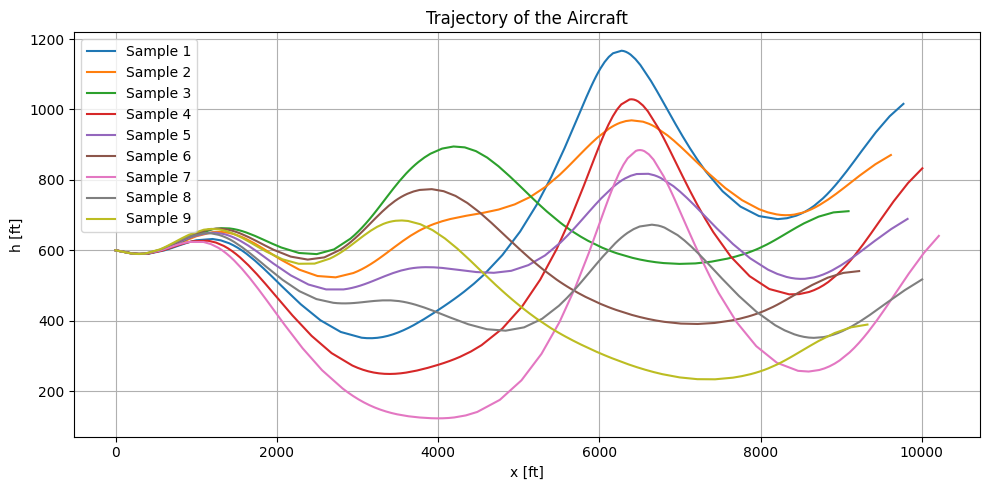

In [29]:
time_grid = res_q["time_grid"]
u = res_q["u"]  # shape: (N,)

plt.figure(figsize=(18, 5))
plt.step(time_grid, u, label='Optimal u', linewidth=2)
plt.plot(time_grid, -0.06*np.ones_like(time_grid), 'r.', label='Time Grid Points')
plt.xlabel('Time [s]')
plt.ylabel('u (control)')
plt.title('Adaptive Control $u$ on Adaptive Mesh')
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.figure(figsize=(10, 5))
M = len(res_q['x'])  # Number of PCE samples
for j in range(M):
    plt.plot(res_q['x'][j], res_q['h'][j], label='Sample {}'.format(j+1))
plt.xlabel('x [ft]')
plt.ylabel('h [ft]')
plt.title('Trajectory of the Aircraft')
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.show()